In [9]:
import json
import numpy as np
import pandas as pd
import math
import os
#from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [10]:
def prep_data(path1, path2, path3, path4): 
    df_2016 = pd.read_csv(path1)
    df_2017 = pd.read_csv(path2)
    df_2018 = pd.read_csv(path3)
    df_2019 = pd.read_csv(path4)
    df_2016["season"] = "2016"
    df_2017["season"] = "2017"
    df_2018["season"] = "2018"
    df_2019["season"] = "2019"
    df_all_season = pd.concat([df_2016, df_2017, df_2018, df_2019]).reset_index(drop=True)
    return df_all_season

def regular_data(df_all_season):
    # Get only those rows which have 2 as the 5th digit in game_id (i.e. only regular season games)
    df_all_season = df_all_season[df_all_season["game_id"].astype(str).str[5] == "2"]
    return df_all_season

def preprocess(df_all_season):
    df_all_season = df_all_season[df_all_season.rinkSide.notna() & df_all_season.coordinates_x.notna() & df_all_season.coordinates_y.notna()].reset_index(drop=True)
    df_all_season["offensive_goal_post_x"] = [-89 if i=="right" else 89 for i in df_all_season["rinkSide"]]
    df_all_season["offensive_goal_post_y"] = 0
    df_all_season["shot_distance"] = df_all_season.apply(lambda x: np.sqrt((x['offensive_goal_post_x']-x['coordinates_x'])**2 + (x['offensive_goal_post_y']-x['coordinates_y'])**2), axis=1)
    df_all_season['goal'] = np.where(df_all_season['event']=="Goal", 1, 0)
    df_all_season['shot_angle'] = df_all_season.apply(lambda x: np.arcsin((x['offensive_goal_post_y']-x['coordinates_y'])/(x['shot_distance']+0.0001))*180/math.pi, axis=1)
    df_all_season["empty_net"] = df_all_season["empty_net"].replace(np.nan, False)
    df_all_season['is_empty_net'] = np.where(df_all_season['empty_net']==True, 1, 0)
    return df_all_season

df_all_season = prep_data('2016_clean.csv', '2017_clean.csv', '2018_clean.csv', '2019_clean.csv')
df_all_season = regular_data(df_all_season)
df_all_season = preprocess(df_all_season)

In [ ]:
#df_test_data = pd.read_csv('2020_clean.csv')
df_test_data = pd.read_csv('2020_clean.csv')
df_test_regular_data = regular_data(df_test_data)
df_test_regular_data = preprocess(df_test_regular_data)
# Save the test data to a csv file
# df_test_regular_data.to_csv('test_data_regular.csv', index=False)
df_test_playoff_data = df_test_data[df_test_data["game_id"].astype(str).str[5] == "3"]
df_test_playoff_data = preprocess(df_test_playoff_data)
# Save the test data to a csv file
# df_test_playoff_data.to_csv('test_data_playoff.csv', index=False)
# df_test_playoff_data.head()

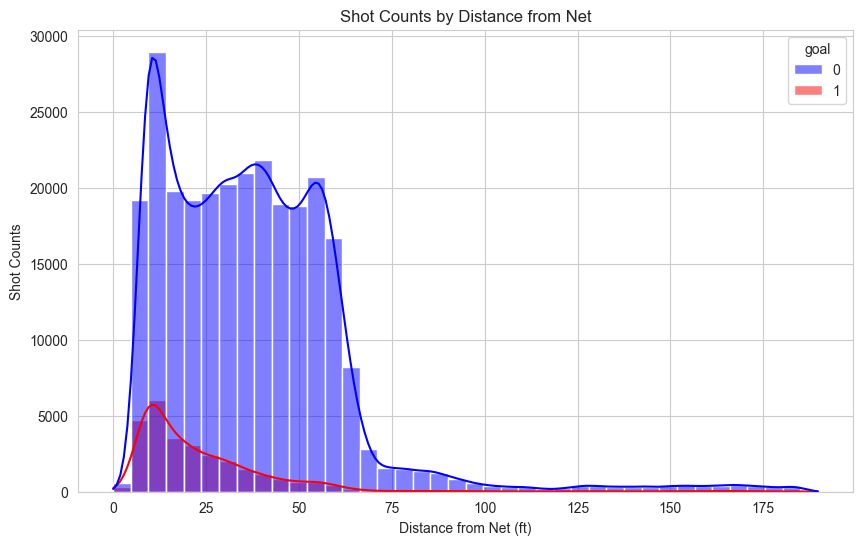

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df_all_season, x='shot_distance', hue='goal', bins=40, kde=True, palette=['blue', 'red'])
plt.title('Shot Counts by Distance from Net')
plt.xlabel('Distance from Net (ft)')
plt.ylabel('Shot Counts')
plt.show()

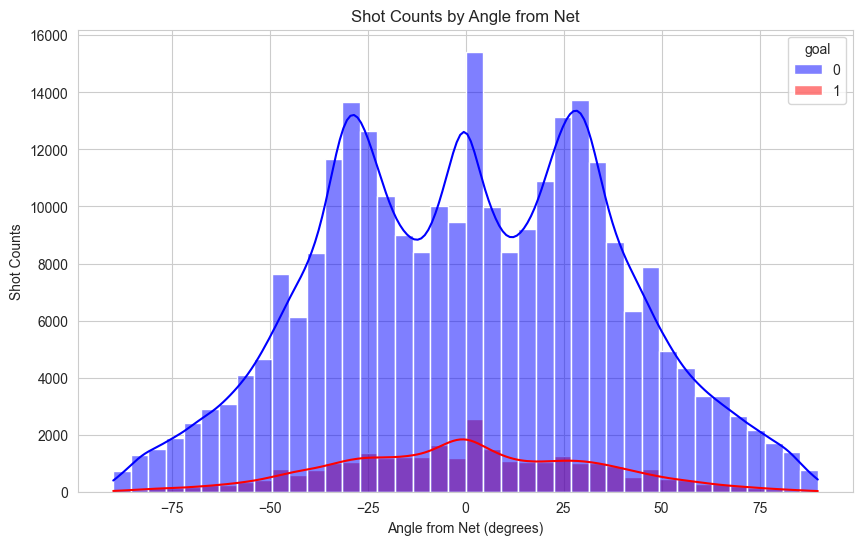

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df_all_season, x='shot_angle', hue='goal', bins=40,kde=True, palette=['blue', 'red'])
plt.title('Shot Counts by Angle from Net')
plt.xlabel('Angle from Net (degrees)')
plt.ylabel('Shot Counts')
plt.show()

<Figure size 1000x600 with 0 Axes>

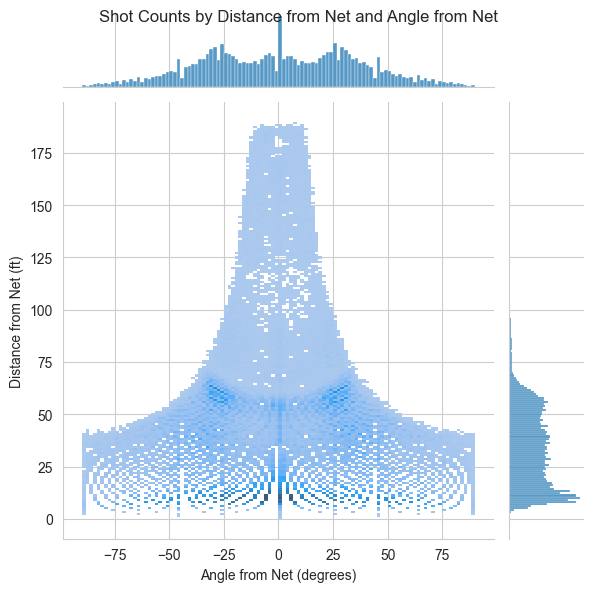

In [18]:
plt.figure(figsize=(10, 6))
# Give the plot a main title above all subplots
sns.jointplot(data=df_all_season, x="shot_angle", y="shot_distance",kind = "hist")
plt.suptitle('Shot Counts by Distance from Net and Angle from Net')
plt.xlabel('Angle from Net (degrees)')
plt.ylabel('Distance from Net (ft)')
plt.show()

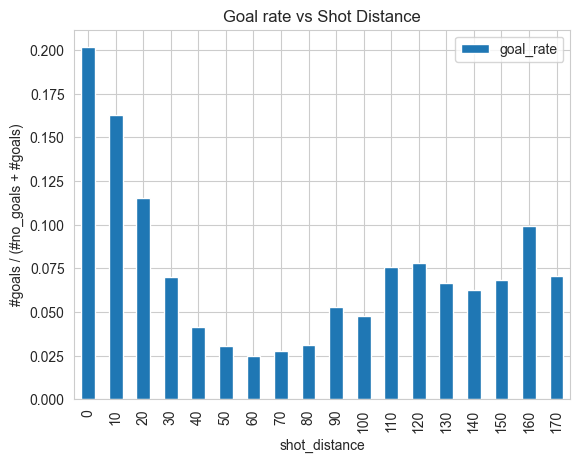

In [19]:
binned_set =[]
y_binned = []
for i in range(0, 180, 10):
    binned_set.append(i)
    subset_df = df_all_season[(df_all_season['shot_distance']<i+10) & (df_all_season['shot_distance']>=i)]
    bin_val = len(subset_df[subset_df['goal']==1])/len(subset_df)
    y_binned.append(bin_val)
df=pd.DataFrame({'shot_distance':binned_set, 'goal_rate':y_binned})

ax = df.plot.bar(x='shot_distance', y='goal_rate')
ax.set_xticklabels(binned_set)
plt.xlabel('shot_distance')
plt.ylabel('#goals / (#no_goals + #goals)')
plt.title("Goal rate vs Shot Distance")
plt.show()

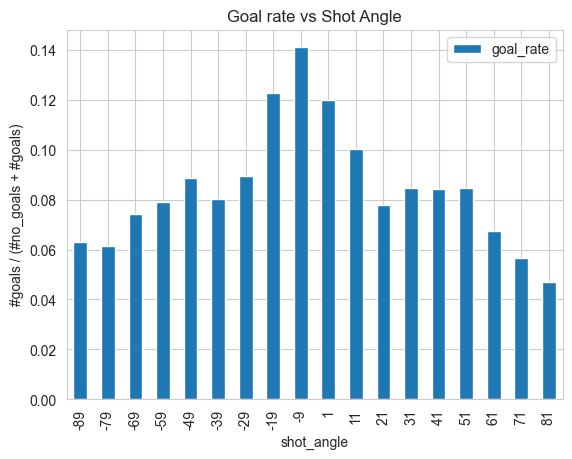

In [20]:
binned_set =[]
y_binned = []
for i in range(int(df_all_season['shot_angle'].min()), int(df_all_season['shot_angle'].max()), 10):
    binned_set.append(i)
    subset_df = df_all_season[(df_all_season['shot_angle']<i+10) & (df_all_season['shot_angle']>=i)]
    bin_val = len(subset_df[subset_df['goal']==1])/len(subset_df)
    y_binned.append(bin_val)
df=pd.DataFrame({'shot_angle':binned_set, 'goal_rate':y_binned})

ax = df.plot.bar(x='shot_angle', y='goal_rate')
ax.set_xticklabels(binned_set)
plt.xlabel('shot_angle')
plt.ylabel('#goals / (#no_goals + #goals)')
plt.title("Goal rate vs Shot Angle")
plt.show()

1    1343
Name: is_empty_net, dtype: int64


Text(0.5, 1.0, 'Empty Net Shot Counts by Distance from Net')

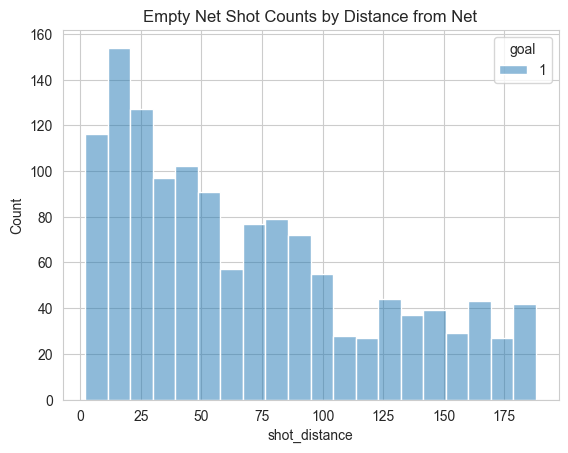

In [21]:
subset_df = df_all_season[(df_all_season.goal == 1) & (df_all_season.is_empty_net == 1)]
print(subset_df.is_empty_net.value_counts())
sns.histplot(subset_df, x='shot_distance', hue='goal', bins=20)
plt.title('Empty Net Shot Counts by Distance from Net')

0    26947
Name: is_empty_net, dtype: int64


Text(0.5, 1.0, 'Non-Empty Net Shot Counts by Distance from Net')

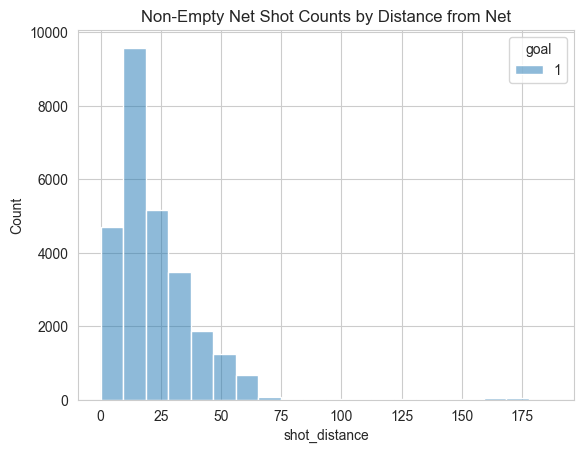

In [22]:
subset_df = df_all_season[(df_all_season.goal == 1) & (df_all_season.is_empty_net == 0)]
print(subset_df.is_empty_net.value_counts())
sns.histplot(subset_df, x='shot_distance', hue='goal', bins=20)
plt.title('Non-Empty Net Shot Counts by Distance from Net')

Text(0.5, 1.0, 'Shot Counts by Distance from Net')

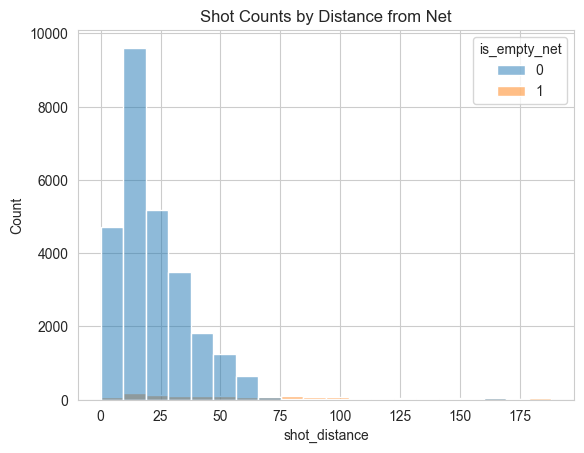

In [23]:
subset_df = df_all_season[(df_all_season.goal == 1)]
sns.histplot(subset_df, x='shot_distance', hue='is_empty_net', bins=20)
plt.title('Shot Counts by Distance from Net')